<h1><center>Data science for Geographers</center></h1>

<h2><center>Practical 4 - Modelling with categorical data</center></h2>

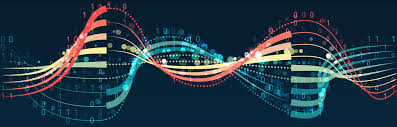

## Contents<a class="anchor" id="contents"></a>

- 1. [Introduction](#section1)
    - [Load the required packages](#section1.1)
    - [Load the data](#section1.2)
- 2. [Working with categorical predictor variables](#section2)
    - [The problem](#section2.1)
    - [Factor variable refresh](#section2.2)
    - [Dummy variables and selecting a reference category](#section2.3)
    - [Exercise](#exercise2)
- 3. [Working with categorical dependant variables?](#section3)
    - [Binary categories versus multiple categories](#section3.1)
    - [Why is modelling categorical outcomes difficult?](#section3.2)
    - [Logistic regression](#section3.3)
    - [Interpretation: logit scale versus odds ratios](#section3.4)
    - [Model fit with logistic regression](section3.5)
    - [Exercise](#exercise3)
- 4. [Conclusions](#section4)


## 1. Introduction<a class="anchor" id="section1"></a>

So far in the course, we have successfully managed to import our data, clean it and recode the necessary variables before finally running our first regression model. Initially we started with just a simple linear regression model. This simple analysis consisted of our dependent variable (the rates of smokers during pregnancy in datazones) predicted by a single independent variable (the density of tobacco retailers in those datazones). Because we know that smoking is predicted by other factors, some of which are also related to your likelihood of living in an area of higher density (i.e. levels of deprivation etc) we then estimated a more complex model where we add these other factors (known as confounders). In the previous practical we then started to look at the mechanics of linear regression and to understand some of the important assumptions we need to make in order to interpret the results.

Up to now, we have been working almost exclusively with continuous data and haven't given any consideration to how we might model categorical data. In this practical, we are going to cover how we go about modelling categorical data, both when we have predictor or independant variables that are categorical, but also when we have outcome or dependent data that is also categorical. The first of these is quite straightforward, but the second requires a different regression modelling approach known as logistic regression.

Ok, so let's go through the usual initial steps.

### Load the required packages<a class="anchor" id="section1.1"></a>

First, let's load the packages that we will need.

In [ ]:
library(tidyverse)

### Load the data<a class="anchor" id="section1.2"></a>

Next let's load our data from before, contained in the `merged_data.csv` file.

In [ ]:
analysis_data <- read_csv("merged_data.csv")

[Back to contents](#contents)

Now let's move onto how we deal with predictor variables that are categorical.

## 2. Working with categorical PREDICTOR variables<a class="anchor" id="section2"></a>

The first step in any analysis involving categorical variables is to identify which of your variables of interest are actually categorical. By default, when R first imports data it treats most variables as numeric. We have seen in previous practicals how to identify the variable type of every variable in our data but also how to convert them into `factor` variables (what R calls categorical data). Most variables are obviously categorical, but in some cases it is not always obvious. For example, age on its own is often considered a continuous variable but in reality it has many characteristics that are more like a categorical variable. It has a pretty finite number of values (e.g. 0 to max 120!) for one thing! Many studies therefore create categorical versions of age (e.g. 26-30, 31-45 etc). As is always the case how you specify your variables depends on your research question and your underlying knowledge of the thing you are studying. 

So let's look at how we can use categorical information as a predictor variable.

The first thing we need to do is check the different types of each of our variables. Remember each variable that is a categorical variable needs to be recognised as a factor (or a `fct` type) by R.

We can do this with the `head` command but we can also use the `str()` command. This command is very helpful as it compactly displays the contents of our data object, including the type of each variable. Check the variable type for `simd_rank` and `simd_quintile`. You should see they are both type `dbl`, in other words numeric.

In [ ]:
head(analysis_data)
str(analysis_data)

### The problem<a class="anchor" id="section2.1"></a>

Before we actually change any of the categorical variables into factors, let's have a look at what happens in our regression if we just add them as standard numeric variables. This will hopefully illustrate why we need to use a special approach for them in our later models.

Below, we are running two models; the first is a standard model predicting `smoking_rate` on the basis of `simd_rank` which is a continuous measure (i.e. varies between 1 and approx 6500 (the total number of datazones in our data) showing datazones ranked by deprivation from most deprived to least deprived. The second model, is the same but instead is using the categorical version of SIMD `simd_quintile` which groups the `simd_rank` variable into 5 equal groups (in other words it varies between 1 and 5). This variable is categorical but for the purposes of illustration we have included it as continuous.

In [ ]:
#Run the standard regression once with continuous predictor and then with categorical predictor

continuous_predictor_regression <- lm(smoking_rate ~ simd_rank, data = analysis_data, na.action = na.exclude)
categorical_predictor_regression  <- lm(smoking_rate ~ simd_quintile, data = analysis_data, na.action = na.exclude)

summary(continuous_predictor_regression)
summary(categorical_predictor_regression)

Now look and compare the effect sizes across the models, they are both in the right direction and are negative i.e. as deprivation decreases, smoking rate also decreases. But the size of the effects is very different. The interpretation of both of these models as they stand is as follows: 

- Model 1 (continuous), as deprivation rank decreases by one (i.e. becomes less deprived) smoking rate decreases by <b><i>0.004%</b></i> 
- In model 2 as simd quintile increases by one unit smoking rate decreases by <b><i>6%</b></i>.

The reason for the massive difference in these effects is because the range of values in both is much different, and therefore the relevant change in the outcome from a <b><i>single</b></i> unit change in the predictor is very different as well.

Let's now look at the scatterplot of the these two regressions with a line of best fit added.

In [ ]:
##Show a standard scatterplot
ggplot(analysis_data, aes(x=simd_rank, y=smoking_rate)) +
  geom_point(size=2, shape=23)+
  geom_smooth(method=lm, se=FALSE)

##Show an attemp to show a scatterplot with categorical data
ggplot(analysis_data, aes(x=simd_quintile, y=smoking_rate)) +
  geom_point(size=2, shape=23)+
  geom_smooth(method=lm, se=FALSE)

Hopefully you can see that while it is theoretically possible to run a normal regression with categorical variables, the second model does not do a great job of capturing the underlying relationship. Clearly, it would make more sense to calculate the <b><i>mean</b></i> `smoking_rate` for <b><i>each level</b></I> of the  `simd_quintile` categorical variable. As we will see, this is essentially what R does automatically when adding a factor variable to your regression.

### Factor variable refresh<a class="anchor" id="section2.2"></a>

Ok, so let's now go on to do this properly. First, let's go ahead and create a factor variable version of the `simd_quintile` variable (remember it is currently a numeric variable!). Check the data afterwards to make sure it has been changed appropriately.

In [ ]:
#create and label a new categorical variable
analysis_data <- analysis_data %>% 
    mutate(simd_quintile = as.factor(simd_quintile)) %>% 
    mutate(simd_quintile = fct_recode(simd_quintile,
                                        "Most deprived" = "1", 
                                        "Second" = "2", 
                                        "Third" = "3", 
                                        "Fourth " = "4", 
                                        "Least deprived" = "5"))


#Note that the new variable has been changed to a "fct" and has been relabelled

head(analysis_data)
str(analysis_data)

When working with continuous variables, we tended to look at things like the mean, standard deviation and histograms to examine the distribution of the variable. With categorical data we tend to use tables a lot more.

The code below is how you would go about producing a table showing the numbers of observatons in each `simd_quintile` category. It uses the `group_by` function and the `summarise` function to show us the total counts. The summarise function takes an argument `n=()`. The `n` is basically a function passed to the `summarise` command that says "sum the total number of observations specified in `group_by`".  

In [ ]:
#Now we have created our categorical variable we will want to look at a table of it

#Simple table
analysis_data %>%
  group_by(simd_quintile) %>%
  summarise(n = n())

We can also add some other useful columns of information to the table if we wish including for example the cumulative total, the percentage of the total in each group as well as finally the cumulative percentage. We do this using the `mutate` command followed by the calculations of each, these are:

- `cumsum()` - a function to calculate the cumulative total
- `round((n / sum(n)), 3)` - a calculation for the percentage rounded to 3 significant figures using the `round` function.
- `cumsum(freq = n / sum(n)), 3)` - the calculation of the cumulative percentage combining the various things above

In [ ]:
#Simple table with some additional summary information
analysis_data %>%
  group_by(simd_quintile) %>%
  summarise(n = n()) %>%
  mutate(
    CumulativeTotal = (cumsum(n)),
    percent = round((n / sum(n)), 3),
    cumuPer = round(cumsum(freq = n / sum(n)), 3))

### Dummy variables and selecting a reference category<a class="anchor" id="section2.3"></a>

Ok, now we have our correctly coded categorical variable as a factor. We are ready to run the regression. Because the variable is now a factor, all we have to do is add the variable in the usual way.

In [ ]:
##Now re-run our regression to use new variable
categorical_predictor_regression  <- lm(smoking_rate ~ simd_quintile, data = analysis_data, na.action = na.exclude)
summary(categorical_predictor_regression)

Look at this output. What do you notice is different about it?

We now have 4 coefficients or parameters, whereas before we had 1. Why? 

This is because each coefficient now corresponds to each level of the variable. R has created for us automatically what are known as <b><i>dummy variables</b></i> or what can also be called <b><i>binary variables</b></i>. Dummy variables are variables that take on one of two values; 1 if the value is in the group and zero otherwise. So each level of `simd_quintile` is a dummy variable. If the dummy variable is for level 1, then the value will be 1 if the observation is in level 1 and zero otherwise. For the level 2 dummy variable, the values will be 1 if the observation is on level 2 and zero otherwise and so on.

You might be wondering why 4 and not 5 dummies are given (given the variable has five levels...)?

The reason is that because we are estimating what we call a <b><i>relative effect</b></i> here. It is relative because each coefficient is <b><i>relative</b></i> to level 1 of the categorical variable. So looking at the output above, the second quintile has smoking rates that are 7% lower <i>on average</i> than rates in the first simd quintile. The least deprived quintile has smoking rates that are 22% lower <i>on average</i> than the first level, and so on. In this case, level 1 is acting as what we call the <b><i>reference category</b></i>. Reference in the sense that it is the category to which all of the other categories are compared.

You might be wondering, "what if I wanted to change the reference category"? R by default will use the first category as the reference, but you can change this if you wish to using the `relevel()` function. This function allows you tp specify a level you wish to use as the reference. Let's do this below, making the second level of `simd_quintile` the reference.

In [ ]:
categorical_predictor_regression  <- lm(smoking_rate ~ relevel(simd_quintile, ref = "Second"), data = analysis_data, na.action = na.exclude)
summary(categorical_predictor_regression)

You can see that now all of the groups are being compared to the second level.

Note: don't be confused by the output splitting the table onto a new line. The output looks confusing because the columns can't fit onto a single page so R has broken the output onto separate lines so that the t-statistic and p values are on a new line! 

Of course you can also combine both categorical and continuous predictors in the same model. Let's do this by adding our retailer density variable to the same model we estimated above.

In [ ]:
categorical_predictor_regression  <- lm(smoking_rate ~ retailers_adj + simd_quintile, data = analysis_data, na.action = na.exclude)
summary(categorical_predictor_regression)

As you can see, the interpretation remains the same as before.

### Exercise <a class="anchor" id="exercise2"></a>

1. Produce a table summarising the numbers of datazones that are in different categories of urban and rural


2. Check the type of the existing urban and rural (`urban_rural`) variable and if neccessary convert it to a factor.  


3. Run a regression model predicting smoking rates on the basis of the levels of the urban or rural variable.


4. Repeat the model above, but this time, use "Remote Rural" as the reference category and adjust for the level of deprivation and the retailer density in the datazone. 

In [ ]:
#Solutions
#1.Simple table with some additional summary information
analysis_data %>%
  group_by(urban_rural) %>%
  summarise(n = n()) %>%
  mutate(
    CumulativeTotal = (cumsum(n)),
    percent = round((n / sum(n)), 3),
    cumuPer = round(cumsum(freq = n / sum(n)), 3))

#Just the raw numbers
analysis_data %>%
  group_by(urban_rural) %>%
  summarise(n = n())

#2. Use the str() command to display the variable types
str(analysis_data)

#and convert the urban and rural variable to a factor, note no need to label as labels 
analysis_data <- analysis_data %>% 
    mutate(urban_rural = as.factor(urban_rural))

#3. 
smoking_urban_rural  <- lm(smoking_rate ~ retailers_adj 
                           + urban_rural, 
                           data = analysis_data, 
                           na.action = na.exclude)
summary(smoking_urban_rural)

#4. 
smoking_urban_rural_dep  <- lm(smoking_rate ~ retailers_adj 
                           + relevel(urban_rural, ref = "Remote Rural")
                           + simd_quintile
                           + retailers_adj, 
                           data = analysis_data, 
                           na.action = na.exclude)
summary(smoking_urban_rural_dep)

[Back to contents](#contents)

## 3. Working with categorical DEPENDENT variables<a class="anchor" id="section3"></a>

Ok, so we know how to deal with categorical <b><i>predictor</b></i> variables, but what about categorical <b><i>outcomes</b></i> (dependent variables)?

To illustrate, we are going to use a small subset of the data to make the plots that we are going to produce easier to read. We are going to focus on rural areas for this section, so restricting our analysis to the 1227 rural datazones in Scotland only.

Let's start by creating an additional data object called `rural_only` which consists of just the rural datazones.

In [ ]:
rural_only <- analysis_data %>% 
    filter(urban_rural_2cat == "Rural")

And check we have only the rural datazones by creating a table from this new data object.

In [ ]:
#check we only have urban in this new data
rural_only %>%
  group_by(urban_rural_2cat) %>%
  summarise(n = n())

Next we have to create the variable that we want to predict. For the purposes of illustration we are going to create a binary categorical variable (i.e. one with only two levels) based on the original smoking rates variable. I have chosen an arbitrary cut-off of 20% to divide my categories. So we will be creating a variable that has the values "0" for areas with smoking rates below 20% and "1" for areas that have smoking rates above 20%. Keep in mind that for your own projects you will need to provide a good justification for any categorising decisions you make (based on your research question and the literature).

Note below that for the purposes of logistic regression, the variable <b><i>does not</b></i> have to be a factor type but it <b><i>does</b></i> have to be coded with only zeros and ones (so not e.g. "2" and "3") and it has to have <b><i>two and only two levels</b></i> (we will discuss the situation when we have more than two levels in our outcome variable at the end of the practical).

The code below does this for us and creates a new variable called `smoking_rate_binary`.

In [ ]:
rural_only <- rural_only %>% 
    mutate(smoking_rate_binary = as.numeric(smoking_rate >= 20))

Let's check this new variable to make sure it makes sense using a table as before.

In [ ]:
#Check this new variable
rural_only %>%
  group_by(smoking_rate_binary) %>%
  summarise(n = n())

Ok, now we have our variable.

In [ ]:
smoking_rural  <- lm(smoking_rate_binary ~ simd_rank, 
                           data = rural_only, 
                           na.action = na.exclude)

summary(smoking_rural)

### Why is modelling categorical outcomes difficult?<a class="anchor" id="section3.2"></a>

On the face of it, this regression model looks fine, but let's look at in more detail with a scatterplot.

In [ ]:
ggplot(rural_only, aes(x=simd_rank, y=smoking_rate_binary)) +
  geom_point(size=2, shape=23)+
  geom_smooth(method=lm, se=FALSE)

This is a problem. Clearly our standard linear regression model is not appropriate for this type of data. The modelled line does not accurately reflect the underlying data.

In [ ]:
ggplot(rural_only, aes(x=simd_rank, y=predict(smoking_rural))) +
  geom_point() +
  geom_abline(intercept=0, slope=1) +
  labs(x='SIMD rank', y='Predicted Values', title='Predicted Values from our model')

When working with binary variables like this, what we are effectively doing is working with probabilities, in other words the <b><i>risk</b></i> or <b><i>probability</b></i> of being in the "1" category. In some senses linear regression does provide us with a useful approach as it can simply predict the probabillity of being a "1" rather than the actual value. But, as highlighted below, the area highlighted in red shows us that the model is predicting probabilities that are less than zero (and it could also predict values that are above 1 which is also a problem).

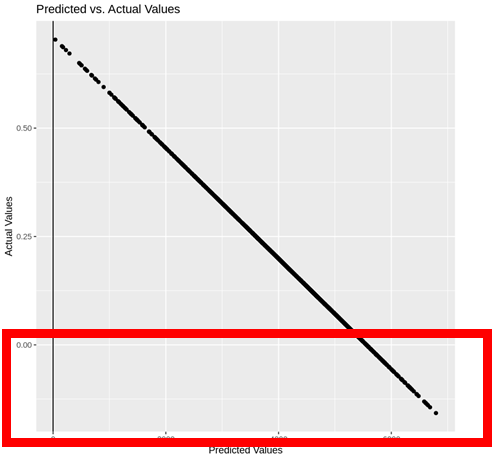

The reason this is the case is because the standard linear model is <b><i>assuming</b></i> that probabilities are <b><i>normally distributed</b></i>. Unfortunately they are not! Instead they follow a different distribution known as the <b>binomial</b> distribution.

You don't need to worry too much about what this means but the binomial distribution refers to the particular context of binary variables. It essentially describes the distribution of expected successes (i.e. the number of "1s" in our binary variable) in an experiment given a particular sample size and underlying probabillity. As an example, here is the distribution of expected numbers of tails if we were to flip a coin 100 times:

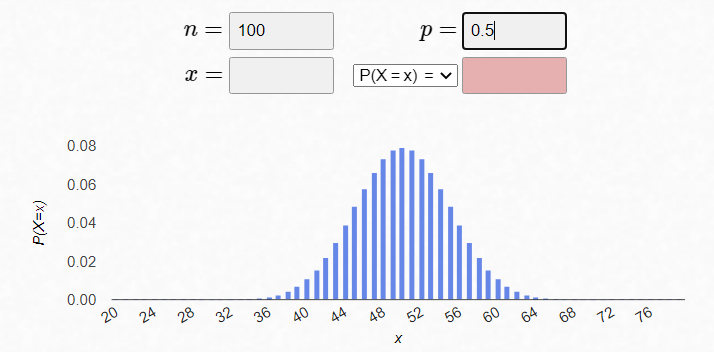

We know that the probabillity of a tails is 50/50 or 0.5 so if we flipped a coin 100 times the probabillity of say:

- 64 tails is very unlikely
- 36 tails is very unlikely
- 50 tails much more likely

Based on the above example, when tossing a coin 100 times, the probably that we would get 64 tails is only 0.00156. In other words less than 1% (0.156%).

You can try out different binomial distributions at this link if you like! This is a helpful tool for visualising and understand probabillities.

https://homepage.divms.uiowa.edu/~mbognar/applets/bin.html

Going back to our data, by using the binomial distribution (rather than the normal distribution) our predicted probabilities look like this instead:

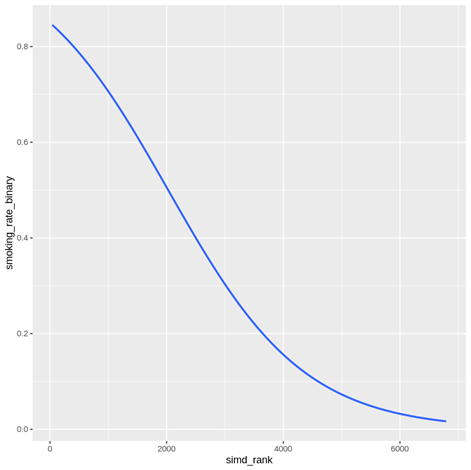

You can see that the fitted line is "flattened" at the ends ensuring that we only get predicted values on the interval 0-1. Incidentally, the curve in the image above has a special name, it is known as the <b><i>logistic curve</b></i>.

This is great, but has introduced another problem for us. Can you think what it is? Looking at this line, what do you see? Is it straight? 

As you should remember from the previous practical, ordinary linear regression is not well equipped to handle non-straight lines. One of the key assumptions of ordinary linear regression is that the relationship between the predictor and outcome variables is linear. So, to model this data we need to extend the concept of regression a little further, and use a technique known as logistic regression (because it is based on predicting probabilities that follow a logistic curve!).

### Logistic regression<a class="anchor" id="section3.3"></a>

Logistic regression is part of a family of statistical models called generalised linear models (GLMs for short). They are generalised because they follow the same basic principles of regression but with some additional steps that allow us to relax the assumption of linearity. In the previous practical I mentioned that one approach to dealing with non-linear relationships is to adjust or transform the dependent variable in such a way that it behaves in a more linear fashion. This is the basis of how we use regression to model binary outcomes. We take the probabilities, carry out a mathematical transformation on them and model them in the same way as with ordinary regression.

In the case of logistic regression this involves:

- Converting the probabilities into odds (like in horse racing i.e. 2:1 or 10:1).
- Taking the natural logarithm of these odds (called the log odds or <b><i>logit</i></b>)
- Fitting a normal regression to this new transformed variable

Odds are calculated according to the following formula:

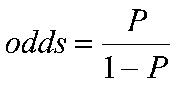

Where <b><i>p</B></I> is the probability. So a probability of 0.8 converts into odds of 4 (i.e. 0.8/(1-0.8) ). A bookmaker would refer to this as 4/1 on! A probability of 0.2 converts into odds of 0.25 (i.e. 0.2/(1-0.2) ). A bookmaker would refer to this as 4/1 against! 

The next step is to take the natural log of the odds. In the simplest terms, this removes the curve in the line. If we take the log of the examples above, we get log-oods or logit values of 1.39 and -1.39 respectively. As you can see, positive log odds are probabilities greater than evens (or 0.5) and negative log-odds are probabilities less than evens.  

The code below does these calculations for illustration.

In [ ]:
#first calculate the odds
0.8/(1-0.8)

#Then take the natural log of this number
log(4)

#We can combine all of this into one command
log(0.8/(1-0.8))

The really helpful thing here is that R does the transformations we did above automatically when running a logistic regression so we don't need to worry about doing these calculations ourselves. But the key to remember is that after the transformation, the models are fitted on the <b><i>new transformed variable</b></i>, i.e. the log-odds.

Let's run a logistic regression, generate some predicted values and see how they look.

The code below runs the logistic regression and then adds a column (`predicted_glm`) to the data object that is the predicted values from this model. It then generates a plot of the predicted values for the predictor variable `simd_rank`. 

Don't worry about the commands, we will look at that in more detail a little bit later on.

In [ ]:
glm_fit <- glm(smoking_rate_binary ~ simd_rank,
              data = rural_only,
              family = binomial(link='logit'),
              na.action = na.exclude)

rural_only <- rural_only %>% 
    mutate(predicted_glm = predict(glm_fit, type="link"))

ggplot(rural_only, aes(x=simd_rank, y=predicted_glm)) + 
    geom_point()

Remember these are predicted values based on our <b><i>transformed variable</i></b> which is on the log-odds scale. As you can see, the predicted values lie perfectly on a straight line so we have met our assumption of linearity. And because (unlike probabilities) the log-odds <b><i>can</b></i> take on values that are less than 0, that is not a problem here either!

However, because we have transformed the variable, the interpretation of these predicted values is not very intuitive (what does a value for log odds actually mean?!). But we can of course reverse the transformation to get back to the more intuitive probabilities as we do below, which gives us our nice logistic curve...

In [ ]:
ggplot(rural_only, aes(x=simd_rank, y=smoking_rate_binary)) +
  geom_smooth(method = "glm", 
    method.args = list(family = "binomial"), 
    se = FALSE) 

The key to remember here is that R does all of this for us in the `glm` model command. We just need to know roughly what is going to be able to interpret the results. 

Before we examine the actual model output, let's just go over the command that produced this output from earlier so we know what each part is doing. Here is the command again:

`glm_fit <- glm(smoking_rate_binary ~ simd_rank, data = rural_only, family = binomial(link='logit'), na.action = na.exclude)`
              
For the most part, the command is the same as the standard linear regression model. The only difference is we use the `glm` command (because we are using a "generalised linear model") instead of `lm` (which is just the "linear model"). We also have to specify the family of distributions that the model will use, in this case this is the "binomial" distribution as we discussed above and how this distribution links to our data. As we are using the log-odds or the logit we specify `logit` as the link.

So lets look at the actual model summary.


In [ ]:
summary(glm_fit)

The model can be interpreted in exactly the same way as a normal linear regression. The coefficient or estimate tells us the change in <b><i>log-odds</b></i> of the outcome given a 1 unit increase in SIMD rank. The only problem is that as we discussed before log-odds on their own are not very meaningful. Instead we need to convert them to what are called <b><i>odds ratios</b></i>.

### Interpretation: logit scale versus odds ratios<a class="anchor" id="section3.4"></a>

In the simplest terms, converting from log-odds/logits to odds ratios is a relatively simple process. All we need to do is exponentiate the coefficients from our models. We can do this using the `exp()` function. 

First we exponentiate the coefficients.

In [ ]:
exp(coef(glm_fit))

And then we do the same to the confidence intervals. 

In [ ]:
exp(confint(glm_fit))

The resulting odds ratios have a specific interpretation. An odds ratio greater than 1 tells us that there is an <b><i>increased</b></i> probabillity of the outcome variable. In this case it would mean an increase in the risk that an area has a smoking rate greater than 20%. The actual effect we observe is less than 1 (0.999) which means that as deprivation reduces, the risk of an area having a smoking rate more than 20% decreases. Odds ratios can also be interpreted as percentages. For example, an odds ratio of 1.5 would mean a 50% <b><i>increase</b></i> in the risk of the outcome variable. Similarly, an odds ratio of 0.75 would mean a 25% (i.e. 1-0.75) <b><i>decrease</b></i> in the risk of the outcome variable.

The confidence intervals have the same interpretation as usual i.e. the interval within which we are 95% confident the true value of the odds ratio lies within. If the interval <b><i>does not</b></i> include zero, it is statistically significant (i.e. there is some difference in the probability) which will be mirrored in the full regression summary output as well (i.e. in terms of the p-value and the significance).

### Model fit with logistic regression<a class="anchor" id="section3.5"></a>

Unfortunately, the standard model fit tools like R-squared, multiple R-squared and adjusted R-squared do not apply to logistic regression. Instead we have to rely on the AIC which we covered in the last practical.

Let's look at the model output again:

In [ ]:
summary(glm_fit)

You can see at the bottom that the AIC has been included automatically. If we were to run another model with an additional variable, we should see a reduction in the AIC and therefore an improvement in the fit of the model. Let's try this by adding the `retailer_adj` variable:

In [ ]:
glm_fit <- glm(smoking_rate_binary ~ simd_rank + retailers_adj,
              data = rural_only,
              family = binomial(link='logit'),
              na.action = na.exclude)

summary(glm_fit)

As you can see this resuts in a slight improvement in the model. Lets try adding simd as a categorical variable and see what difference this makes.

In [ ]:
glm_fit <- glm(smoking_rate_binary ~ simd_quintile + retailers_adj,
              data = rural_only,
              family = binomial(link='logit'),
              na.action = na.exclude)

summary(glm_fit)

Looking at the AIC, this doesn't seem to have improved the model. 

Remember here, the interpretation of the coefficients when using categorical predictors is also in reference to the specified level, in this case the most deprived. Let's go ahead and calculate the odds ratios.

In [ ]:
exp(coef(glm_fit))
exp(confint(glm_fit))

Looking at these odds ratios, they are all below 1 indicating that compared to the most deprived areas, all other SIMD quintiles have a much lower risk of smoking rates above 20%. For the least deprived decile, there is a 99.6% reduction (i.e. 1-0.003652404) in risk of a high smoking rate above 20%. 

### Exercise<a class="anchor" id="exercise3"></a>

1. Calculate the log odds for a probability of 0.6. Experiment with some other probabilities if you like, especially ones above and below 0.5!


2. Conduct a logistic regression predicting whether a datazone has a smoking rate more than 20% for <b><i>just the urban datazones</i></b> based on the density of tobacco retailers. Make sure you can interpret the output including calcualting the relevant odds ratios. Note: you may need to create some of these variables and/or make sure they are factor variables where relevant.


3. Repeat the above but additionally adjust this model for SIMD quintile deprivation.


4. Compare the AIC values, which is the better fitting model?

In [ ]:
#code solutions
#1.
log(0.6/(1-0.6))

#2.
#Create the urban only subset of data
urban_only <- analysis_data %>% 
    filter(urban_rural_2cat == "Urban")

#Add a binary smoking variable (areas with smoking rates above 20%)
urban_only <- urban_only %>% 
    mutate(smoking_rate_binary = as.numeric(smoking_rate >= 20))

#run the model
urban_model_retailers <- glm(smoking_rate_binary ~ retailers_adj,
              data = urban_only,
              family = binomial(link='logit'),
              na.action = na.exclude)

#Calculate the odds ratios
exp(coef(urban_model_retailers))
exp(confint(urban_model_retailers))

#2. 
urban_model_retailers_simd <- glm(smoking_rate_binary ~ retailers_adj + simd_quintile,
              data = urban_only,
              family = binomial(link='logit'),
              na.action = na.exclude)

exp(coef(urban_model_retailers_simd))
exp(confint(urban_model_retailers_simd))

#4. 

summary(urban_model_retailers)
summary(urban_model_retailers_simd)

#The second model is clearly the better fitting model.


[Back to contents](#contents)

## Conclusion

We have covered a lot today! But you should now be equipped to carry out modelling on both continuous and categorical outcome variables and also be able to use both types of variables as predictors.

One thing we haven't discussed today is the situation where we have a categorical outcome variable with <b><i>more</b></i> than two levels. Let's say for example, that we wanted to predict whether an area was in one of five groups of retailer densities (i.e. a variable similar to the `simd_quintile` but for tobacco retailer density). If we wanted to predict this, we couldnt use logistic regression as this will only work for variables with two categories. Unfortunately, this is very difficult to do. There is an approach known as <b><i>multinomial</b></i> regression modelling which can do this but it is an advanced technique and not widely used because it is very difficult to interpret. Instead, the most common thing to do is recode that variable into a binary selecting an appropriate grouping strategy based on a combination of existing literature (so that your work is comparable to existing studies) but also your specific research question.  

The final thing to note is that model diagnostics are much less straightforward when using logistic regression. With ordinary linear modelling, we can use the various plots we covered in the last practical. But equivalents for logistic regression are not as easy to come by. However, as we covered, it is ok to use the AIC as a measure of fit.

[Back to contents](#contents)